In [1]:
from pathlib import Path
from typing import Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
import brevitas.nn as qnn

In [4]:
project_path = Path.cwd().parent
data_path = project_path / 'data' / 'SpO2'

input_path = data_path / 'SpO2_input_cleaned4%.csv'
output_path = data_path / 'SpO2_output_cleaned4%.csv'

assert input_path.exists(), "file does not exist"
assert output_path.exists(), "file does not exist"

weight_bit_width = 2
input_bit_width = 5  # originally, SpO2 data are 5 bits ([0-31])
save_weight_path = project_path/f"weights/SpO2/qat/quant_fc_{input_bit_width}bits_data_{weight_bit_width}bits_weights.pth"
assert save_weight_path.exists()
print(f"weight path = {save_weight_path}")

weight path = /home/dk/Desktop/projects/PocketHHE/weights/SpO2/qat/quant_fc_5bits_data_2bits_weights.pth


## Dataset

In [5]:
split_ratio = (0.6, 0.2, 0.2)

class SpO2(Dataset):
    split: str

    def __init__(self, input_path: Path, output_path: Path, 
                 quantize: bool = False, split: str = 'train'):
        self.split = split
        x = np.loadtxt(input_path, dtype=int, delimiter=',')
        y = np.loadtxt(output_path, dtype=int, delimiter=',')
        assert len(x) == len(y), "input and output have different number of examples"
        
        if quantize:
            x = (x - np.min(x)) / (np.max(x) - np.min(x))
            x = (x * (2**input_bit_width - 1)).astype(int)
            # x = x.float() / 4

        train_split_index = int(x.shape[0] * split_ratio[0])
        val_split_index = int(x.shape[0] * (split_ratio[0] + split_ratio[1]))
        if split == 'train':
            self.x = x[:train_split_index, :]
            self.y = y[:train_split_index]
        elif split == 'eval':
            self.x = x[train_split_index:val_split_index, :]
            self.y = y[train_split_index:val_split_index]
        elif split == 'test':
            self.x = x[val_split_index:, :]
            self.y = y[val_split_index:]
        else:
            raise ValueError(f"no option for 'split = {split}'")
        
        self.x = torch.tensor(self.x, dtype=torch.float)
        self.y = torch.tensor(self.y, dtype=torch.float)
        self.y = torch.unsqueeze(self.y, dim=1)
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
    def print_info(self):
        print(f"----------- {self.split} dataset info -----------")
        print(f"{self.x.shape = }")
        print(f"{self.y.shape = }")
        print(f"input unique values = {self.x.unique()}")
        print(f"maximum input value = {torch.max(self.x).item()}")
        print(f"minimum input value = {torch.min(self.x).item()}")

In [6]:
train_dataset = SpO2(input_path=input_path, 
                     output_path=output_path, 
                     split='train', quantize=False)
val_dataset = SpO2(input_path=input_path, 
                   output_path=output_path, 
                   split='eval', quantize=False)
test_dataset = SpO2(input_path=input_path, 
                    output_path=output_path, 
                    split='test', quantize=False)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [7]:
train_dataset.print_info()
val_dataset.print_info()
test_dataset.print_info()

----------- train dataset info -----------
self.x.shape = torch.Size([14950, 300])
self.y.shape = torch.Size([14950, 1])
input unique values = tensor([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
        15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28.,
        29., 30.])
maximum input value = 30.0
minimum input value = 1.0
----------- eval dataset info -----------
self.x.shape = torch.Size([4984, 300])
self.y.shape = torch.Size([4984, 1])
input unique values = tensor([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
        15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28.,
        29., 30.])
maximum input value = 30.0
minimum input value = 1.0
----------- test dataset info -----------
self.x.shape = torch.Size([4984, 300])
self.y.shape = torch.Size([4984, 1])
input unique values = tensor([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.,
        16., 17., 18., 19., 20., 21., 22., 

class = 0.0


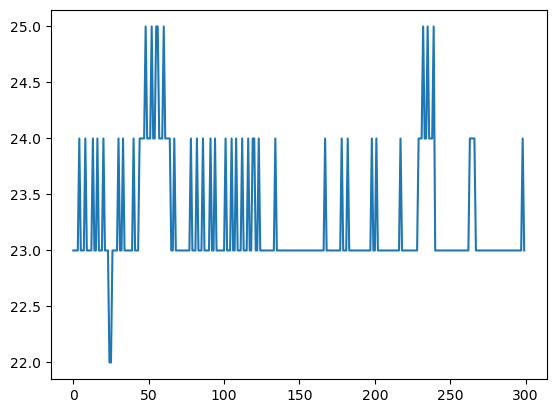

In [7]:
example_input = train_dataset[4][0]
example_output = train_dataset[4][1]
print(f'class = {example_output.item()}')
plt.plot(example_input)

In [8]:
for x, y in test_loader:
    print(x.shape, y.shape)
    print(x.unique())
    # print((x.dtype))
    break

torch.Size([64, 300]) torch.Size([64, 1])
tensor([16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28., 29.,
        30.])


## Model

In [8]:
def accuracy(outputs, labels):
    preds = outputs.round()
    assert len(preds) == len(labels)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class BaseModel(nn.Module):
    """
    PytorchLightining style
    """
    def training_step(self, batch):
        inp, labels = batch
        out = self(inp)  # Generate predictions
        loss = F.binary_cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch) -> Dict:
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.binary_cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)  # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs) -> Dict:
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()  # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result) -> None:
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch + 1, result['val_loss'], result['val_acc']))


class SpO2OneFCQuantModel(BaseModel):
    """
    1 linear layer
    """
    def __init__(self):
        super().__init__()
        self.fc1 = qnn.QuantLinear(in_features=300, out_features=1, bias=False, 
                                   weight_bit_width=weight_bit_width,
                                   return_quant_tensor=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, xb):
        out = self.fc1(xb)
        out = self.sigmoid(out)

        return out
    

class SpO2TwoFCQuantModel(BaseModel):
    """
    2 linear layers + 1 square activation
    """
    def __init__(self):
        super().__init__()
        self.fc1 = qnn.QuantLinear(in_features=300, out_features=128, bias=False, 
                                   weight_bit_width=weight_bit_width,
                                   return_quant_tensor=True)
        self.fc2 = qnn.QuantLinear(in_features=128, out_features=1, bias=False, 
                                    weight_bit_width=weight_bit_width,
                                    return_quant_tensor=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, xb):
        out = self.fc1(xb)
        out = out * out
        out = self.fc2(out)
        out = self.sigmoid(out)

        return out

## Train and evaluate

In [60]:
def evaluate(model, val_loader) -> Dict:
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, 
        train_loader, val_loader, test_loader, 
        file_path, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    high_acc = 0.8
    for epoch in range(epochs):
        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)

        if epoch >= 2:
            eval_dict = evaluate(model, test_loader)
            print(str(epoch) + "\t" + str(eval_dict))
            if eval_dict['val_acc'] > high_acc:
                high_acc = eval_dict['val_acc']
                torch.save(model.state_dict(), file_path)
                print(f"Saved into {file_path.relative_to(project_path)}")

    return history

In [ ]:
model = SpO2TwoFCQuantModel()
model

In [ ]:
history = [evaluate(model, val_loader)]
history += fit(epochs=150, lr=0.001, model=model, 
               train_loader=train_loader, 
               val_loader=val_loader, 
               test_loader=test_loader, 
               file_path=save_weight_path, 
               opt_func=torch.optim.Adam)

## Inference on Test Dataset (1-FC model)

In [9]:
model = SpO2OneFCQuantModel()
model.load_state_dict(
    torch.load(save_weight_path,
    map_location=torch.device('cpu'))
)

<All keys matched successfully>

### Automatic inference with Brevitas

In [12]:
def evaluate(model, val_loader) -> Dict:
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

acc = evaluate(model, test_loader)['val_acc']
print(f"test accuracy with trained {weight_bit_width}-bit weights = {acc}")

test accuracy with trained 2-bit weights = 0.8245192170143127


/home/dk/miniconda3/envs/pockethhe/lib/python3.9/site-packages/torch/nn/modules/activation.py:295: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:363.)
  return torch.sigmoid(input)


### Manual Inference

1FC

In [18]:
model = SpO2OneFCQuantModel()
model.load_state_dict(
    torch.load(save_weight_path,
    map_location=torch.device('cpu'))
)

total_acc = 0
max_value = -9999
min_value = 9999
torch_dtype = torch.int16

fc1 = model.fc1.int_weight()
print(f"{fc1.shape = }")
print(f"{fc1.unique() = }")
fc1 = fc1.to(dtype=torch_dtype)
fc1 = torch.transpose(fc1, 0, 1)

sigmoid = nn.Sigmoid()

for inp, label in test_loader:
    inp = inp.to(dtype=torch_dtype)
    out = torch.matmul(inp, fc1)
    
    if torch.max(out) > max_value:
        max_value = torch.max(out)
    if torch.min(out) < min_value:
        min_value = torch.min(out)

    out = sigmoid(out)
    pred = out.round()
    acc = (pred == label)
    total_acc += acc.sum()

print(f"got {total_acc / len(test_dataset) * 100:.2f}% accuracy")
print(f"{max_value = }")
print(f"{min_value = }")

fc1.shape = torch.Size([1, 300])
fc1.unique() = tensor([-1,  0,  1], dtype=torch.int8)
got 82.44% accuracy
max_value = tensor(224, dtype=torch.int16)
min_value = tensor(-187, dtype=torch.int16)


2FC

In [11]:
total_acc = 0
max_value = -9999
min_value = 9999
torch_dtype = torch.int16

fc1 = model.fc1.int_weight()
print(f"{fc1.shape = }")
print(f"{fc1.unique() = }")
fc1 = fc1.to(dtype=torch_dtype)
fc1 = torch.transpose(fc1, 0, 1)

if isinstance(model, SpO2TwoFCQuantModel):
    fc2 = model.fc2.int_weight()
    print(f"{fc2.shape = }")
    print(f"{fc2.unique() = }")
    fc2 = fc2.to(dtype=torch_dtype)
    fc2 = torch.transpose(fc2, 0, 1)

sigmoid = nn.Sigmoid()

for inp, label in test_loader:
    inp = inp.to(dtype=torch_dtype)
    out = torch.matmul(inp, fc1)

    if isinstance(model, SpO2TwoFCQuantModel):
        out = out * out
        out = torch.matmul(out, fc2)
        
    if torch.max(out) > max_value:
        max_value = torch.max(out)
    if torch.min(out) < min_value:
        min_value = torch.min(out)

    out = sigmoid(out)
    pred = out.round()
    acc = (pred == label)
    total_acc += acc.sum()


print(f"got {total_acc / len(test_dataset) * 100:.2f}% accuracy")
print(f"{max_value = }")
print(f"{min_value = }")

fc1.shape = torch.Size([1, 300])
fc1.unique() = tensor([-1,  0,  1], dtype=torch.int8)
got 82.44% accuracy
max_value = tensor(224, dtype=torch.int16)
min_value = tensor(-187, dtype=torch.int16)


### Export integer weights to csv file

In [13]:
fc1_np = fc1.numpy()
fc1_df = pd.DataFrame(fc1_np)
fc1_df.to_csv(project_path/f"weights/SpO2/qat/quant_fc_{input_bit_width}bits_data_{weight_bit_width}bits_weights.csv", 
              index=False,
              header=False)